<h1 align="center">Volume 4: Total Variation.</h1>

    Bryant McArthur
    February 2, 2023
    Math 439

In [54]:
import numpy as np
import scipy.linalg as la
from matplotlib import pyplot as plt
from matplotlib import cm
from imageio import imread, imwrite
import imageio as im
from PIL import Image, ImageOps

# Problem 1

Using $20$ $x$ steps, $250$ time steps, $a=-1$, $b=1$, $\alpha = 1$, $\beta=7$, and a final time of $0.2$, plot the solution that minimizes (17.4). It should match figure 17.1.

In [19]:
# Initialize everything
a,b = -1,1
alpha, beta = 1,7
final_T = .2
time_steps = 250
x_steps = 20

dt = final_T/time_steps
dx = (b-a)/x_steps

x0 = np.linspace(a,b,x_steps+1)
y0 = (beta - alpha)/(b-a)*(x0-a) + alpha

In [6]:
if dt/dx**2 > .5:
    print("Stability Condition Fails")

u = np.empty((2,x_steps+1))
u[0] = (beta - alpha)/(b-a)*(x0-a) + alpha
u[1] = (beta - alpha)/(b-a)*(x0-a) + alpha

In [8]:
def rhs(y):
    yp = (np.roll(y,-1) - np.roll(y,1))/(2*dx)
    ypp = (np.roll(y,-1) - 2*y + np.roll(y,1))/dx**2
    y[1:-1] -= dt*(1 + yp[1:-1]**2 - y[1:-1]*ypp[1:-1])
    
for i in range(time_steps):
    rhs(u[1])
    if la.norm(np.abs((u[0] - u[1]))) < 1e-5: 
        break
    u[0] = u[1]
    
print("Difference in iteration is ", la.norm(np.abs((u[0] - u[1]))))
print("Final time = ", i*dt)

Difference in iteration is  0.0
Final time =  0.19920000000000002


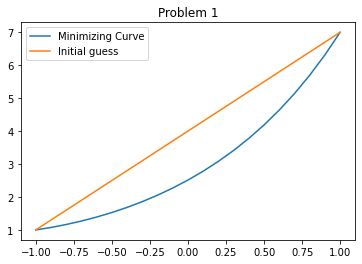

In [30]:
# Plot it
plt.plot(x0, u[-1], label="Minimizing Curve")
plt.plot(x0, y0, label="Initial guess")
plt.title("Problem 1")
plt.legend()
plt.show()

# Problem 2

Using $\Delta t = 1e{-3},$ $\lambda = 40,$ $\Delta x = 1,$ and $\Delta y = 1$, implement the numerical scheme mentioned above to obtain a solution $u$. (So $\Omega = [0,n_x]\times [0,n_y]$, where $n_x$ and $n_y$ represent the number of pixels in the $x$ and $y$ dimensions, respectively.) Take 250 steps in time. Plot the original image as well as the image with noise. Compare your results with Figure 17.3.

In [51]:
# Make a noisy balloon image
imagename = "balloons_color.jpg"
changed_pixels=4000

IM = imread(imagename, as_gray=True)/255
IM_x, IM_y = IM.shape

for lost in range(changed_pixels):
    x_,y_ = np.random.randint(1,IM_x-2), np.random.randint(1,IM_y-2)
    val = np.random.randn() + .5
    IM[x_,y_] = max(min(val,1),0)
    
imwrite("noised_"+imagename, IM)

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


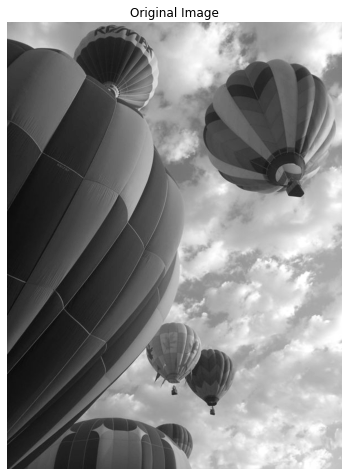

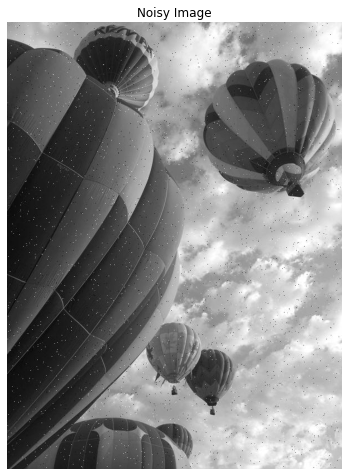

In [108]:
# Plot both
im = Image.open(imagename)
plt.figure(figsize=(6,9))
plt.imshow(ImageOps.grayscale(im), cmap='gray')
plt.axis("off")
plt.title("Original Image")
plt.show()

plt.figure(figsize=(6,9))
im = Image.open("noised_"+imagename)
plt.imshow(im, cmap='gray')
plt.axis("off")
plt.title("Noisy Image")
plt.show()

In [110]:
# Initialize everything
dt = 1e-3
lam = 40
dx = 1
dy = 1
time_steps = 250

if dt/dx**2 > .5:
    print("Stability Condition Fails")

u = imread("noised_"+imagename, as_gray=True)/255

# Run the diffusion approach
def rhs(u):
    uxx = (np.roll(u,-1,axis=1) - 2*u + np.roll(u,1,axis=1))/dx**2
    uyy = (np.roll(u,-1,axis=0) - 2*u + np.roll(u,1,axis=0))/dy**2
    ut = -(u - IM - lam * (uxx+uyy))
    
    u[1:-1,1:-1] = dt*ut[1:-1,1:-1] + u[1:-1,1:-1]


for i in range(time_steps):
    u_old = u.copy()
    rhs(u)
    if la.norm(np.abs((u - u_old))) < 1e-5: 
        break

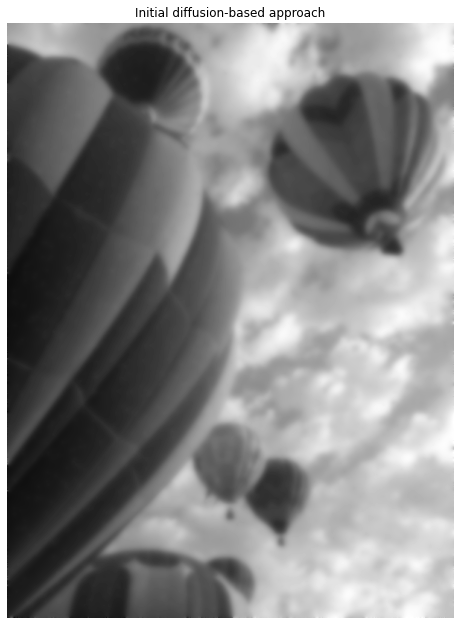

In [111]:
# Plot it
plt.figure(figsize=(8,12))
plt.imshow(u, cmap='gray')
plt.title("Initial diffusion-based approach")
plt.axis("off")
plt.show()

# Problem 3

Using $\Delta t = 1e-3, \lambda = 1, \Delta x = 1,$ and $ \Delta y = 1$, implement the numerical scheme mentioned above to obtain a solution $u$.  Take 200 steps in time. Display both the diffusion-based and total variaton images of the balloon. Compare your results with
Figure 17.3. How small should ε be?

In [112]:
# Initialize everything
dt = 1e-3
lam = 1
dx = 1
dy = 1
time_steps = 200
eps = 1e-4

u = imread("noised_"+imagename, as_gray=True)/255

# Run the total variation approach
def rhs(u):
    ux = (np.roll(u,-1,axis=1) - np.roll(u,1,axis=1))/2
    uy = (np.roll(u,-1,axis=0) - np.roll(u,1,axis=0))/2
    uxx = (np.roll(u,-1,axis=1) - 2*u + np.roll(u,1,axis=1))/dx**2
    uxy = (np.roll(ux,-1,axis=0) - np.roll(ux,1,axis=0))/2
    uyy = (np.roll(u,-1,axis=0) - 2*u + np.roll(u,1,axis=0))/dy**2
    
    ut = -lam*(u-IM) + (uxx*uy**2 + uyy*ux**2 - 2*ux*uy*uxy) / (eps + ux**2 + uy**2)**(3/2)
    
    u[1:-1,1:-1] = dt*ut[1:-1,1:-1] + u[1:-1,1:-1]

for i in range(time_steps):
    u_old = u.copy()
    rhs(u)
    if la.norm(np.abs((u - u_old))) < 1e-5: 
        break

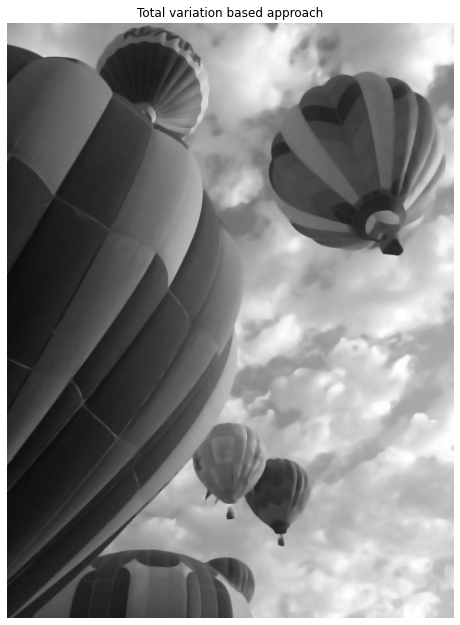

In [113]:
# Plot it
plt.figure(figsize=(8,12))
plt.imshow(u, cmap='gray')
plt.title("Total variation based approach")
plt.axis("off")
plt.show()

Epsilon = 10^-4 gives a good denoised picture